In [1]:
import sys,os
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as nplin
import scipy as sp
from scipy.linalg import pinv as spinv
from sklearn.metrics import pairwise_distances

In [2]:
def operators(s,RBM=0):
    #generate terms in the energy function
    n_seq,n_var = s.shape
    if RBM == 0:
        out = np.zeros((n_seq,n_var+int(n_var*(n_var-1)/2.0)))
    else:
        out = np.zeros((n_seq,n_var+(n_var-RBM)*RBM))
    jindex = 0
    for index in range(n_var):
        out[:,jindex] = s[:,index]
        jindex +=1
    if RBM==0:
        for index in range(n_var-1):
            for index1 in range(index+1,n_var):
                out[:,jindex] = s[:,index]*s[:,index1]
                jindex +=1
    else:
        for index in range(n_var-RBM):
            for index1 in range(n_var-RBM,n_var):
                out[:,jindex] = s[:,index]*s[:,index1]
                jindex +=1
    return out
def energy_ops(ops,w):
    return np.sum(ops*w[np.newaxis,:],axis=1)#/np.power(w.shape[0],0.25)
def energy(w,seqs):
    return np.mean(seqs*seqs.dot(w),axis=1)
def generate_seqs(n_var,n_seq,n_sample=30,large=False,num_large=4,RBM=0):
    samples = np.random.choice([1.0,-1.0],size=n_var*n_seq*n_sample,replace=True).reshape(n_seq*n_sample,n_var)
    ops = operators(samples,RBM=RBM)
    n_ops = ops.shape[1]
##    w_true = np.random.rand(n_var+int(n_var*(n_var-1)/2.0))-0.5
    w_true = (np.random.rand(ops.shape[1])-0.5)/np.sqrt(float(n_var))
#     if RBM > 0: w_true[n_var:] *= np.sqrt(float(n_var))
    if large and num_large>0: #putting in some large couplings
        indices_large = np.random.choice(range(n_var,n_ops),size=num_large,replace=False)
        for l_index in range(num_large):
            w_true[indices_large[l_index]] *= 10.0

    sample_energy = energy_ops(ops,w_true)
    p = np.exp(sample_energy)
    p = p/np.sum(p)
    out_samples = np.random.choice(np.arange(n_seq*n_sample),size=n_seq,replace=True,p=p)
    return w_true,samples[out_samples],p[out_samples],sample_energy[out_samples]

In [3]:
def eps_machine_step(n_seq,w,ops,eps_scale,alpha):
    obs_energies_w = energy_ops(ops,w)
    sec_order = np.tanh(w*eps_scale)
    probs_w = (-obs_energies_w*(1-eps_scale)).reshape(n_seq)
    max_obs = np.max(probs_w)
    probs_w = np.exp(probs_w - max_obs)
    probs_w /= np.sum(probs_w)
    ops_expect_w = np.sum(probs_w[:,np.newaxis]*ops,axis=0)
    return alpha*(ops_expect_w - sec_order)

def log_prob_given(s,col,w):
    s_temp = np.copy(s)
    s_temp[:,col] = -s_temp[:,col]
    return np.log(1.0/(1.0 + np.exp(energy_ops(operators(s_temp),w)-energy_ops(operators(s),w))))

def tau_update(n_seq,n_var,RBM,ops,w):
    sigma_i = ops[:,:n_var-RBM]
    if RBM>0:
        tau_A =  ops[:,n_var-RBM:n_var]
        w_iA = (w[-(n_var-RBM)*RBM:].reshape((n_var-RBM,RBM)))
        v_A = (w[n_var-RBM:n_var].reshape((RBM)))
        u_i = (w[:n_var-RBM].reshape((n_var-RBM)))
        combo = u_i[np.newaxis,:] + w_iA.dot(tau_A.T).T
        #     prob_sigma_before = np.mean(np.sum(sigma_i*combo-np.log(2*np.cosh(combo)),axis=1),axis=0)
        rand = np.random.rand(n_seq,RBM)
        alt_tau = np.random.choice([1,-1],size=(n_seq,RBM))
        combo_tau = v_A[np.newaxis,:] + sigma_i.dot(w_iA)
        prob_tau = (tau_A-alt_tau)*combo_tau #-np.log(2*np.cosh(combo_tau))
        tau_temp = 1.0/(1.0+np.exp(prob_tau))
        rand_choice = tau_temp >= rand # present tau_A[index] is less likely
        s_temp = np.copy(ops[:,:n_var])
        s_temp[:,n_var-RBM:n_var][rand_choice] = (alt_tau[rand_choice])
        combo = u_i[np.newaxis,:] + w_iA.dot(s_temp[:,n_var-RBM:n_var].T).T
        prob_sigma_orig = np.mean(np.sum(sigma_i*combo-np.log(2*np.cosh(combo)),axis=1),axis=0)
        rand = np.random.rand(n_seq,n_var-RBM)
        alt_sigma = np.random.choice([1,-1],size=(n_seq,n_var-RBM))
        prob_sigma = (sigma_i-alt_sigma)*combo #-np.log(2*np.cosh(combo))
        sigma_temp = 1.0/(1.0+np.exp(prob_sigma))
        rand_choice = sigma_temp >= rand # present sigma[index] is less likely
        s_temp1 = np.copy(s_temp[:,:n_var])
        s_temp1[:,:n_var-RBM][rand_choice] = (alt_sigma[rand_choice])
        combo1 = u_i[np.newaxis,:] + w_iA.dot(s_temp1[:,n_var-RBM:n_var].T).T
        prob_sigma_fake = np.mean(np.sum(s_temp1[:,:n_var-RBM]*combo1-np.log(2*np.cosh(combo1)),axis=1),axis=0)
        ops_new = operators(s_temp1,RBM=RBM)
    else:
#         w_iA = np.zeros(n_var,n_var)
#         u_i = w[:n_var]
#         j_index = n_var
#         for index in range(n_var-1):
#             for index1 in range(index+1,n_var):
#                 w_iA[index,index1] = w[jindex]
#                 jindex +=1
#         w_iA += w_iA.T #symmetric
        energy_orig = energy_ops(ops,w)
        prob_sigma_fake = 0.0
        prob_sigma_orig = 0.0
        s_temp1,s_new = np.copy(ops[:,:n_var]),np.copy(ops[:,:n_var])
        for col in range(n_var):
            rand = np.random.rand(n_seq)
            s_temp = np.copy(ops[:,:n_var])
            s_temp[:,col] = np.random.choice([1,-1],size=(n_seq))
            prob_flip = 1.0/(1.0+np.exp(energy_orig - energy_ops(operators(s_temp,RBM=0),w)))
            rand_choice = prob_flip >= rand # present sigma[col] is less likely
            s_temp1[rand_choice,col] = s_temp[rand_choice,col]
            s_new[rand_choice,col] = s_temp[rand_choice,col]
            prob_sigma_fake += np.mean(log_prob_given(s_temp1,col,w))
            s_temp1 = np.copy(ops[:,:n_var])
            prob_sigma_orig += np.mean(log_prob_given(s_temp1,col,w))
        ops_new = operators(s_new)
    return operators(s_temp,RBM=RBM),ops_new,prob_sigma_orig-prob_sigma_fake

#s is spins including random configs of hidden spins
def eps_machine_rbm_EM(w_true,w,s,eps_scale=.01,max_iter=50,alpha=0.05,RBM=0,W_rep=30):
    n_seq,n_var = s.shape
    s_temp = np.copy(s)
    s_temp[:,n_var-RBM:n_var] = np.random.choice([1,-1],size=(n_seq,RBM))
    
    ops = operators(s_temp,RBM=RBM)
    ops_flip = np.copy(ops)
    prob_sig,eigs_list = [],[]
    for iterate in range(max_iter):
        w_new = np.copy(w)
#         w_new += eps_machine_step(n_seq,w,ops,eps_scale,alpha)
#        if iterate>W_rep: w_new -= (iterate/float(max_iter))*eps_machine_step(n_seq,w,ops_flip,eps_scale,alpha)
        
        for w_rep in range(int(W_rep)): #more w updates before trying to update the hidden spins
            delta_w_new = eps_machine_step(n_seq,w_new,ops,eps_scale,alpha)
            if w_rep == 0:
                if iterate > 0: 
                    size_dw_init_prev,size_dw_final_prev = size_dw_init,size_dw
                size_dw_init = nplin.norm(delta_w_new)
            size_dw = nplin.norm(delta_w_new)
            w_new += delta_w_new
#             print(iterate,'w_rep',w_rep,size_dw)
            if size_dw/size_dw_init < 0.5: break
#         eps_scale = 0.5*min(1.0,1.0/np.max(np.abs(w)))
#         print('eps',eps_scale)
        w = np.copy(w_new)
        ops,ops_flip,prob_sigma_orig_fake = tau_update(n_seq,n_var,RBM,ops,w)
        prob_sig.append(prob_sigma_orig_fake)
        
        # print(iterate,prob_sigma_bef,prob_sigma)
        if 1==1:#iterate%(int(max_iter/5))==0:
            if RBM>0:
                w_iA = (w[-(n_var-RBM)*RBM:].reshape((n_var-RBM,RBM)))
                w_ij = w_iA.dot(w_iA.T)
                eigs,u = nplin.eigh(w_ij)
                wtrue_iA = (w_true[-(n_var-RBM)*RBM:].reshape((n_var-RBM,RBM)))
                wtrue_ij = wtrue_iA.dot(wtrue_iA.T)
                eigs_true,u = nplin.eigh(wtrue_ij)
                #                 print('eps',eps_scale,'iterate',iterate,nplin.norm(eigs-eigs_true))
                eigs_list.append(nplin.norm(eigs-eigs_true))
                plt.scatter(eigs_true,eigs,alpha=0.4)
                if iterate==0: plt.plot(eigs_true,eigs_true,'k-')
            else:
                #                 print('eps',eps_scale,'iterate',iterate,nplin.norm(w-w_true))
                plt.scatter(w_true,w,alpha=0.4)
    
        if iterate > 0:
            if np.sqrt((size_dw-size_dw_final_prev)**2 + (size_dw_init-size_dw_init_prev)**2) < 0.01*size_dw: 
                print('ending w_rep',w_rep,'iterate',iterate)
                break
        for ww_rep in range(max(1,int(w_rep/np.sqrt(float(iterate+1))))): #notice how many iterations we're doing!!
            delta_w_flip = eps_machine_step(n_seq,w_new,ops_flip,eps_scale,alpha)
            w_new -= delta_w_flip
        w = w_new
    plt.show()
    plt.close()
    plt.plot(np.arange(iterate+1),prob_sig,'ro')
    plt.show()
    plt.close()
    if RBM>0:
#         s[:,-RBM:] = ops[:,n_var-RBM:n_var] #this is mixing up the simulated order of the hidden spins!!!
        # so need to order correctly to make correct predictions of hidden spins        
        plt.plot(np.arange(iterate+1),eigs_list,'ko')
        plt.show()
        plt.close()

In [4]:
n_var,n_seq = 10,10000
np.random.seed(0)
RBM0 = 0
w_true,seqs,probs,energies = generate_seqs(n_var,n_seq,large=False,num_large=0,RBM=RBM0)

n_seq  5000
eps  0.5
ending w_rep 15 iterate 9


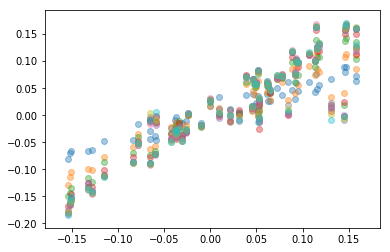

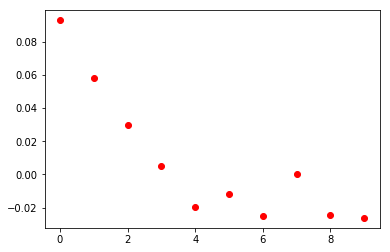

eps  0.75


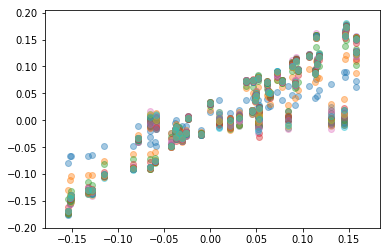

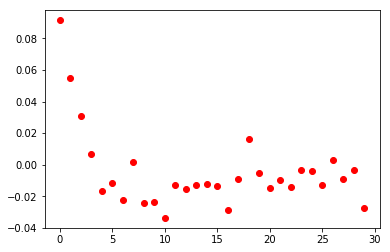

In [5]:
#for n_part in range(2000,5001,2000):
n_part = 5000
print('n_seq ',n_part)
for eps in [0.5,0.75]: #np.arange(300./float(n_part),901./float(n_part),300./float(n_part)):#,0.1,0.2]:
    print('eps ',eps)
    np.random.seed(13)
    if RBM0 == 0:
        w_trial = np.zeros(n_var+int((n_var-1)*n_var*0.5)) #-0.5
    else:
        w_trial = np.random.rand(n_var+(n_var-RBM0)*RBM0) - 0.5
    eps_machine_rbm_EM(w_true,w_trial,seqs[:n_part],max_iter=30,eps_scale=eps,RBM=RBM0)